In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import os
import random

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor

In [16]:
data_dir = '/kaggle/input/new-york-city-taxi-fare-prediction'

### View Dataset Files
#### Size, No. of Lines, First few Lines

In [17]:
!ls -lh {data_dir}

total 5.4G
-rw-r--r-- 1 nobody nogroup  486 Jul 18 01:28 GCP-Coupons-Instructions.rtf
-rw-r--r-- 1 nobody nogroup 336K Jul 18 01:28 sample_submission.csv
-rw-r--r-- 1 nobody nogroup 960K Jul 18 01:28 test.csv
-rw-r--r-- 1 nobody nogroup 5.4G Jul 18 01:31 train.csv


In [18]:
!wc -l {data_dir}/train.csv

55423856 /kaggle/input/new-york-city-taxi-fare-prediction/train.csv


In [19]:
!wc -l {data_dir}/test.csv

9914 /kaggle/input/new-york-city-taxi-fare-prediction/test.csv


In [20]:
!wc -l {data_dir}/sample_submission.csv

9915 /kaggle/input/new-york-city-taxi-fare-prediction/sample_submission.csv


In [21]:
!head {data_dir}/train.csv

key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.84161,40.712278,1
2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.76127,-73.991242,40.750562,2
2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.98713,40.733143,-73.991567,40.758092,1
2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1
2011-01-06 09:50:45.0000002,12.1,2011-01-06 09:50:45 UTC,-74.000964,40.73163,-73.972892,40.758233,1
2012-11-20 20:35:00.0000001,7.5,2012-11-20 20:35:00 UTC,-73.980002,40.751662,-73.973802,40.764842,1
2012-01-04 17:22:00.00000081,16.5,2012-01-04 17:22:00 UTC,-73.9513,40.774138,-73.990095,40.751048,1
2012-12-03 13:10:00.000000125,9,2012-12-03 13:10:00 UTC,-74.006462,40.726713,-73.99

In [22]:
!head {data_dir}/test.csv

key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320007324219,40.7638053894043,-73.981430053710938,40.74383544921875,1
2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862182617188,40.719383239746094,-73.998886108398438,40.739200592041016,1
2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.75126,-73.979654,40.746139,1
2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.98116,40.767807,-73.990448,40.751635,1
2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1
2012-12-01 21:12:12.0000005,2012-12-01 21:12:12 UTC,-73.960983,40.765547,-73.979177,40.740053,1
2011-10-06 12:10:20.0000001,2011-10-06 12:10:20 UTC,-73.949013,40.773204,-73.959622,40.770893,1
2011-10-06 12:10:20.0000003,2011-10-06 12:10:20 UTC,-73.777282,40.646636,-73.985083,40.759368,1
2011-10-06 12:10:20.0000002,2011-10-06 12:10:20 UTC,-74.01409

In [23]:
!head {data_dir}/sample_submission.csv

key,fare_amount
2015-01-27 13:08:24.0000002,11.35
2015-01-27 13:08:24.0000003,11.35
2011-10-08 11:53:44.0000002,11.35
2012-12-01 21:12:12.0000002,11.35
2012-12-01 21:12:12.0000003,11.35
2012-12-01 21:12:12.0000005,11.35
2011-10-06 12:10:20.0000001,11.35
2011-10-06 12:10:20.0000003,11.35
2011-10-06 12:10:20.0000002,11.35


### Observations
* Supervised Learning Regression Problem.
* 5.5 GB in size.
* 5.5 million rows of training data.
* Target column is fare_amount.

### Loading Training Set
* Ignore key column.
* Specify data types.
* Sample 1% of data(~500k rows).

In [153]:
sample_fractions = 0.1

In [154]:
selected_cols = 'fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count'.split(',')
selected_cols

['fare_amount',
 'pickup_datetime',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'passenger_count']

In [155]:
dtypes = {
    'fare_amount': 'float32',
     'pickup_longitude': 'float32',
     'pickup_latitude': 'float32',
     'dropoff_longitude': 'float32',
     'dropoff_latitude': 'float32',
     'passenger_count': 'uint8'
}

def skip_row(row_idx):
    if row_idx == 0:
        return False
    return random.random() > sample_fractions
    
random.seed(42) 
df = pd.read_csv(data_dir+'/train.csv', 
                 usecols=selected_cols, 
                 parse_dates=['pickup_datetime'],
                 dtype=dtypes, 
                 skiprows=skip_row)

In [156]:
df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,16.9,2010-01-05 16:52:16+00:00,-74.016045,40.711304,-73.979271,40.782005,1
1,16.5,2012-01-04 17:22:00+00:00,-73.951302,40.774139,-73.990097,40.751049,1
2,8.9,2009-09-02 01:11:00+00:00,-73.980659,40.733871,-73.991539,40.758137,2
3,4.1,2009-11-06 01:04:03+00:00,-73.991600,40.744713,-73.983078,40.744682,2
4,4.0,2014-12-06 20:36:22+00:00,-73.979813,40.751904,-73.979446,40.755482,1
...,...,...,...,...,...,...,...
5542597,6.0,2014-10-18 07:51:00+00:00,-73.997681,40.724380,-73.994148,40.717796,1
5542598,5.7,2010-11-18 07:08:58+00:00,-73.997589,40.735889,-73.984558,40.754055,1
5542599,8.0,2013-12-21 14:03:00+00:00,-73.976486,40.765919,-73.991524,40.759857,6
5542600,13.0,2013-09-04 20:20:00+00:00,-73.995605,40.725712,-73.954651,40.716702,1


## Load Test Set

In [157]:
test_df = pd.read_csv(data_dir+'/test.csv', dtype=dtypes, parse_dates=['pickup_datetime'])

In [158]:
test_df

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44+00:00,-73.982521,40.751259,-73.979652,40.746140,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12+00:00,-73.981163,40.767807,-73.990448,40.751637,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12+00:00,-73.966049,40.789776,-73.988564,40.744427,1
...,...,...,...,...,...,...,...
9909,2015-05-10 12:37:51.0000002,2015-05-10 12:37:51+00:00,-73.968124,40.796997,-73.955643,40.780388,6
9910,2015-01-12 17:05:51.0000001,2015-01-12 17:05:51+00:00,-73.945511,40.803600,-73.960213,40.776371,6
9911,2015-04-19 20:44:15.0000001,2015-04-19 20:44:15+00:00,-73.991600,40.726608,-73.789742,40.647011,6
9912,2015-01-31 01:05:19.0000005,2015-01-31 01:05:19+00:00,-73.985573,40.735432,-73.939178,40.801731,6


In [159]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5542602 entries, 0 to 5542601
Data columns (total 7 columns):
 #   Column             Dtype              
---  ------             -----              
 0   fare_amount        float32            
 1   pickup_datetime    datetime64[ns, UTC]
 2   pickup_longitude   float32            
 3   pickup_latitude    float32            
 4   dropoff_longitude  float32            
 5   dropoff_latitude   float32            
 6   passenger_count    uint8              
dtypes: datetime64[ns, UTC](1), float32(5), uint8(1)
memory usage: 153.3 MB


In [160]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5.542602e+06,5.542602e+06,5.542602e+06,5.542569e+06,5.542569e+06,5.542602e+06
mean,1.136259e+01,-7.250569e+01,3.991776e+01,-7.250184e+01,3.991749e+01,1.686349e+00
std,4.109730e+01,1.284903e+01,1.017996e+01,1.300960e+01,9.816180e+00,1.324577e+00
min,-3.000000e+02,-3.439245e+03,-3.492264e+03,-3.379079e+03,-3.547887e+03,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073493e+01,-7.399140e+01,4.073402e+01,1.000000e+00
50%,8.500000e+00,-7.398180e+01,4.075265e+01,-7.398016e+01,4.075314e+01,1.000000e+00
75%,1.250000e+01,-7.396708e+01,4.076712e+01,-7.396368e+01,4.076809e+01,2.000000e+00
max,9.396336e+04,3.457626e+03,3.376602e+03,3.442185e+03,3.400392e+03,2.080000e+02


In [161]:
df['pickup_datetime'].min(), df['pickup_datetime'].max()

(Timestamp('2009-01-01 00:01:56+0000', tz='UTC'),
 Timestamp('2015-06-30 23:59:54+0000', tz='UTC'))

### Observations
* No Null Values.
* fair_amount ranges from -52 to 499.
* Dates Range from 1st Jan 2009 to 30th June 2015


### Test Data

In [162]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   key                9914 non-null   object             
 1   pickup_datetime    9914 non-null   datetime64[ns, UTC]
 2   pickup_longitude   9914 non-null   float32            
 3   pickup_latitude    9914 non-null   float32            
 4   dropoff_longitude  9914 non-null   float32            
 5   dropoff_latitude   9914 non-null   float32            
 6   passenger_count    9914 non-null   uint8              
dtypes: datetime64[ns, UTC](1), float32(4), object(1), uint8(1)
memory usage: 319.6+ KB


In [163]:
test_df.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974716,40.751041,-73.973656,40.751740,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252190,40.573143,-74.263245,40.568974,1.000000
25%,-73.992500,40.736125,-73.991249,40.735253,1.000000
50%,-73.982327,40.753052,-73.980015,40.754065,1.000000
75%,-73.968012,40.767113,-73.964062,40.768757,2.000000
max,-72.986534,41.709557,-72.990967,41.696682,6.000000


In [164]:
test_df['pickup_datetime'].min(), test_df['pickup_datetime'].max()

(Timestamp('2009-01-01 11:04:24+0000', tz='UTC'),
 Timestamp('2015-06-30 20:03:50+0000', tz='UTC'))

### Test Set Observations
* 9914 rows.
* No Missing Values.
* Pickup date range is same as training set.

## Exploratary Data Analysis

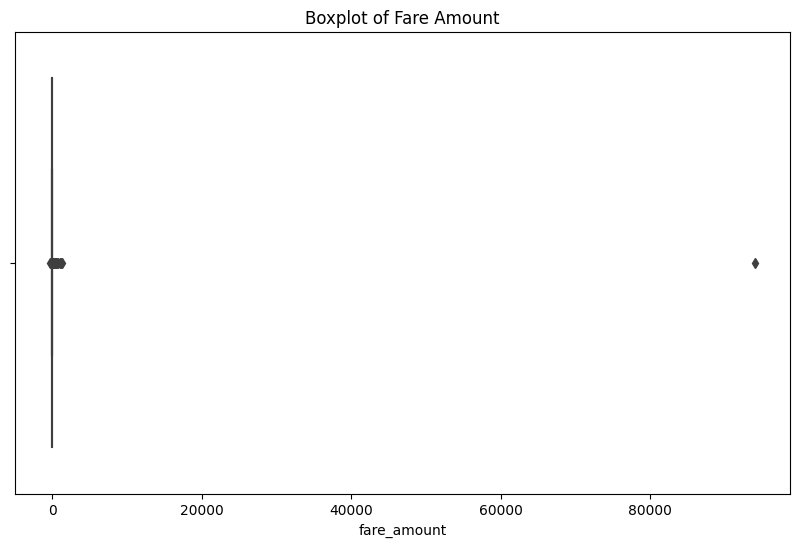

In [165]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['fare_amount'])
plt.title('Boxplot of Fare Amount')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


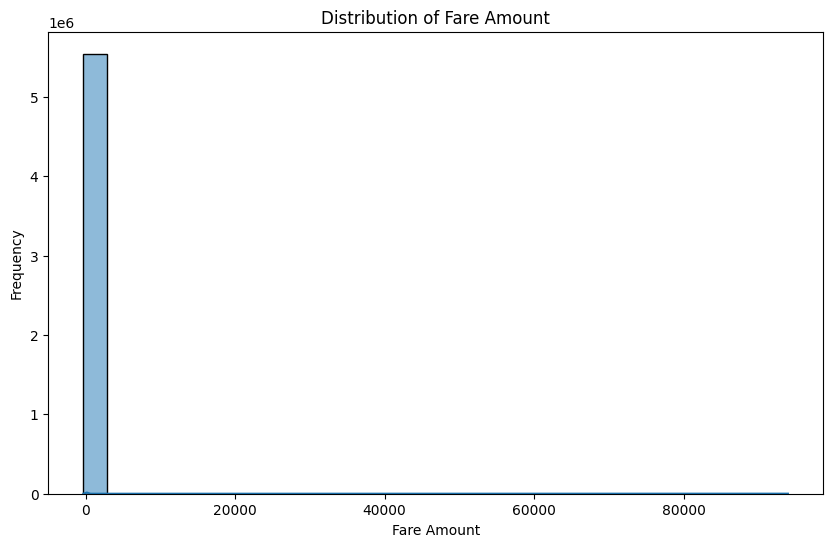

In [166]:
plt.figure(figsize=(10, 6))
sns.histplot(df['fare_amount'], bins=30, kde=True)
plt.title('Distribution of Fare Amount')
plt.xlabel('Fare Amount')
plt.ylabel('Frequency')
plt.show()

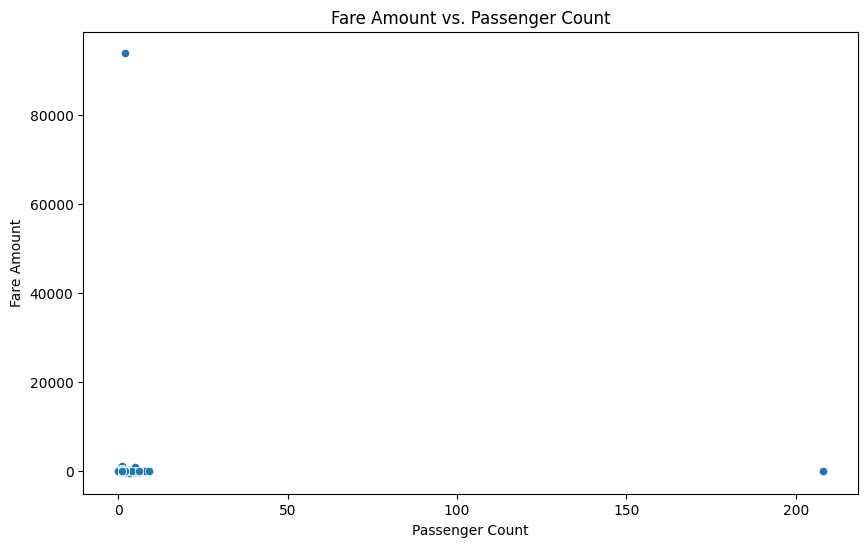

In [167]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='passenger_count', y='fare_amount', data=df)
plt.title('Fare Amount vs. Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Fare Amount')
plt.show()


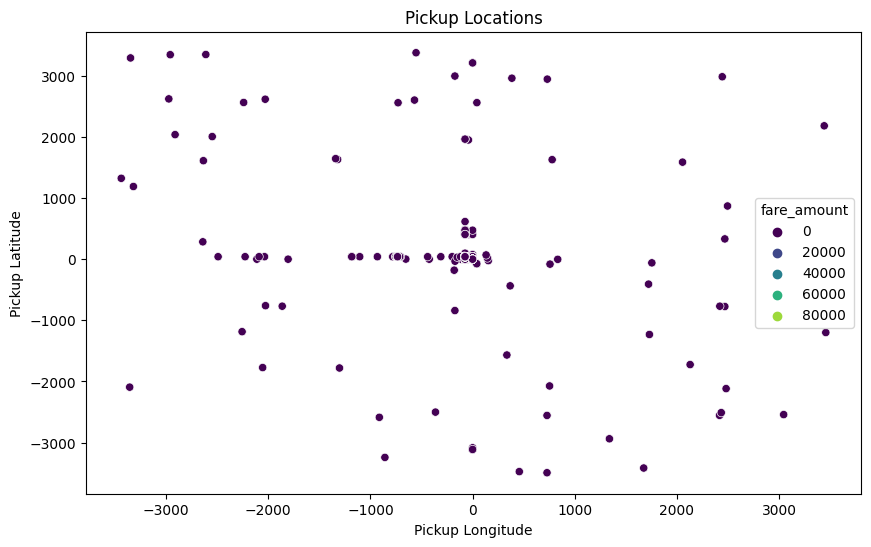

In [168]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='pickup_longitude', y='pickup_latitude', hue='fare_amount', data=df, palette='viridis')
plt.title('Pickup Locations')
plt.xlabel('Pickup Longitude')
plt.ylabel('Pickup Latitude')
plt.show()

/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


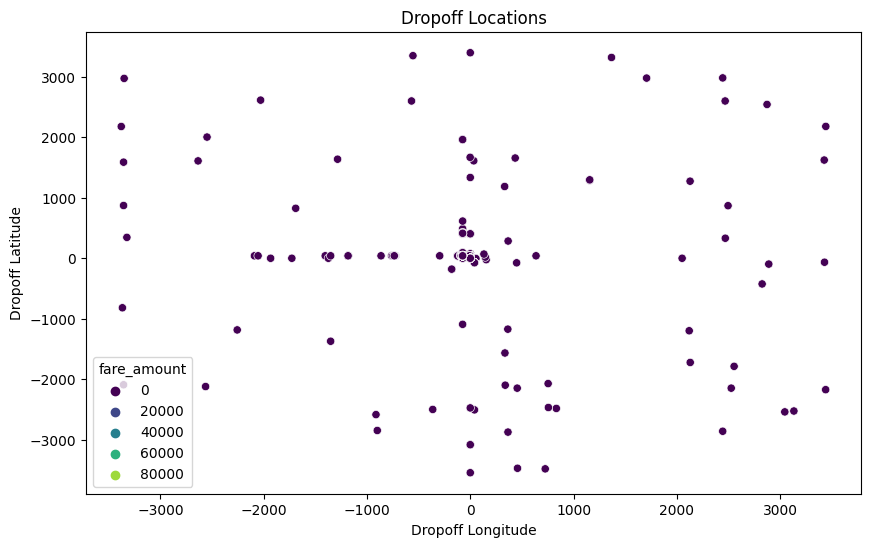

In [169]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='dropoff_longitude', y='dropoff_latitude', hue='fare_amount', data=df, palette='viridis')
plt.title('Dropoff Locations')
plt.xlabel('Dropoff Longitude')
plt.ylabel('Dropoff Latitude')
plt.show()


In [170]:
# Convert 'pickup_datetime' to datetime
#df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

# Extract hour, day of week, and month
#df['hour'] = df['pickup_datetime'].dt.hour
#df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
#df['month'] = df['pickup_datetime'].dt.month

In [171]:
# Distribution of Pickup Hours
#fig = px.histogram(df, x='hour', nbins=24, title='Distribution of Pickup Hours')
#fig.update_layout(xaxis_title='Hour of the Day', yaxis_title='Frequency')
#fig.show()

In [172]:
# Fare Amount by Day of the Week
#plt.figure(figsize=(10, 6))
#sns.histplot(df['day_of_week'], bins=7, kde=True)
#plt.title('Distribution of Pickup Days')
#plt.xlabel('Day of the Week')
#plt.ylabel('Frequency')
#plt.show()


In [173]:
# Distribution of Pickup Months
#fig = px.histogram(df, x='month', nbins=12, title='Distribution of Pickup Months')
#fig.update_layout(xaxis_title='Month', yaxis_title='Frequency')
#fig.show()

In [174]:
df.head(5)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,16.9,2010-01-05 16:52:16+00:00,-74.016045,40.711304,-73.979271,40.782005,1
1,16.5,2012-01-04 17:22:00+00:00,-73.951302,40.774139,-73.990097,40.751049,1
2,8.9,2009-09-02 01:11:00+00:00,-73.980659,40.733871,-73.991539,40.758137,2
3,4.1,2009-11-06 01:04:03+00:00,-73.991600,40.744713,-73.983078,40.744682,2
4,4.0,2014-12-06 20:36:22+00:00,-73.979813,40.751904,-73.979446,40.755482,1


## Prepare Dataset for Training

In [175]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [176]:
len(train_df), len(val_df)

(4434081, 1108521)

In [177]:
train_df = train_df.dropna()
val_df = val_df.dropna()

#### Extract Input and Output

In [178]:
train_df.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count'],
      dtype='object')

In [179]:
input_cols = ['pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count']

In [180]:
target_cols = 'fare_amount'

#### Training 

In [181]:
train_input = train_df[input_cols]

In [182]:
train_target = train_df[target_cols]

In [183]:
train_input

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
2056898,-73.783417,40.648640,-73.738358,40.770729,6
2987026,-73.960716,40.780994,-73.969803,40.765274,1
838145,-73.973808,40.752071,-73.949394,40.777279,1
4760740,-73.975105,40.753578,-73.976768,40.735027,1
2580632,-73.921036,40.756550,-73.943451,40.747372,2
...,...,...,...,...,...
1570006,-73.980797,40.774883,-73.981026,40.744617,1
2234489,-73.961388,40.780155,-73.956810,40.767910,2
4926484,-73.949440,40.781200,-73.982399,40.738453,1
4304572,-73.987167,40.766186,-73.990158,40.738064,1


In [184]:
train_target

2056898    40.0
2987026     6.0
838145      9.0
4760740     8.0
2580632     6.1
           ... 
1570006    11.3
2234489     7.5
4926484    12.1
4304572    10.5
1692743     6.1
Name: fare_amount, Length: 4434058, dtype: float32

#### Validation

In [185]:
val_inputs = val_df[input_cols]

In [186]:
val_targets = val_df[target_cols]

In [187]:
val_inputs

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
46408,-73.988754,40.742519,-74.009453,40.724522,3
329608,-73.991356,40.750160,-73.950020,40.776012,1
2067850,-73.947594,40.779243,-73.947594,40.779243,1
1591386,-73.995781,40.749180,-73.998596,40.764050,1
2859740,-73.965401,40.759190,-73.992882,40.756805,1
...,...,...,...,...,...
2499227,-73.781693,40.646824,-73.988777,40.753441,1
1883362,-73.992516,40.724434,-74.010063,40.721027,1
1649038,-73.978119,40.752354,-73.975952,40.760128,1
3574549,-73.964340,40.797283,-73.967796,40.794338,5


In [188]:
val_targets

46408       8.5
329608     13.7
2067850     3.3
1591386     6.5
2859740    10.9
           ... 
2499227     5.7
1883362     7.3
1649038     4.9
3574549     2.9
2902400     8.5
Name: fare_amount, Length: 1108511, dtype: float32

#### Test

In [189]:
test_inputs = test_df[input_cols]

In [190]:
test_inputs

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,-73.973320,40.763805,-73.981430,40.743835,1
1,-73.986862,40.719383,-73.998886,40.739201,1
2,-73.982521,40.751259,-73.979652,40.746140,1
3,-73.981163,40.767807,-73.990448,40.751637,1
4,-73.966049,40.789776,-73.988564,40.744427,1
...,...,...,...,...,...
9909,-73.968124,40.796997,-73.955643,40.780388,6
9910,-73.945511,40.803600,-73.960213,40.776371,6
9911,-73.991600,40.726608,-73.789742,40.647011,6
9912,-73.985573,40.735432,-73.939178,40.801731,6


## Train & Evaluate Hardcoded Model

In [191]:
class MeanRegressor:
    def fit(self, inputs, targets):
        self.mean = targets.mean()
    
    def predict(self, inputs):
        return np.full(inputs.shape[0], self.mean)

In [192]:
mean_model = MeanRegressor()

In [193]:
mean_model.fit(train_input, train_target)

In [194]:
mean_model.mean

11.367966

In [195]:
train_preds = mean_model.predict(train_input)
train_preds

array([11.367966, 11.367966, 11.367966, ..., 11.367966, 11.367966,
       11.367966], dtype=float32)

In [196]:
val_preds = mean_model.predict(val_inputs)
val_preds

array([11.367966, 11.367966, 11.367966, ..., 11.367966, 11.367966,
       11.367966], dtype=float32)

In [197]:
def rmse(targets, preds):
    return mean_squared_error(targets, preds, squared = False)

In [198]:
train_rmse = rmse(train_target, train_preds)
train_rmse

45.684223

In [199]:
val_rmse = rmse(val_targets, val_preds)
val_rmse

9.838236

## Train & Evaluate Baseline Model
#### Linear Regression

In [200]:
linear_model = LinearRegression()

In [201]:
linear_model.fit(train_input, train_target)

LinearRegression()

In [202]:
train_preds = linear_model.predict(train_input)

In [203]:
train_preds

array([11.798815 , 11.285545 , 11.285625 , ..., 11.285577 , 11.285504 ,
       11.2855015], dtype=float32)

In [204]:
train_target

2056898    40.0
2987026     6.0
838145      9.0
4760740     8.0
2580632     6.1
           ... 
1570006    11.3
2234489     7.5
4926484    12.1
4304572    10.5
1692743     6.1
Name: fare_amount, Length: 4434058, dtype: float32

In [205]:
rmse(train_target, train_preds)

45.683903

In [206]:
val_preds = linear_model.predict(val_inputs)

In [207]:
rmse(val_targets, val_preds)

9.837348

In [208]:
test_inputs

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,-73.973320,40.763805,-73.981430,40.743835,1
1,-73.986862,40.719383,-73.998886,40.739201,1
2,-73.982521,40.751259,-73.979652,40.746140,1
3,-73.981163,40.767807,-73.990448,40.751637,1
4,-73.966049,40.789776,-73.988564,40.744427,1
...,...,...,...,...,...
9909,-73.968124,40.796997,-73.955643,40.780388,6
9910,-73.945511,40.803600,-73.960213,40.776371,6
9911,-73.991600,40.726608,-73.789742,40.647011,6
9912,-73.985573,40.735432,-73.939178,40.801731,6


In [209]:
test_preds = linear_model.predict(test_inputs)

In [210]:
test_preds

array([11.285555, 11.285542, 11.285561, ..., 11.798418, 11.797409,
       11.797222], dtype=float32)

In [211]:
sub_df = pd.read_csv(data_dir+'/sample_submission.csv')

In [212]:
sub_df

,key,fare_amount
0,2015-01-27 13:08:24.0000002,11.35
1,2015-01-27 13:08:24.0000003,11.35
2,2011-10-08 11:53:44.0000002,11.35
3,2012-12-01 21:12:12.0000002,11.35
4,2012-12-01 21:12:12.0000003,11.35
...,...,...
9909,2015-05-10 12:37:51.0000002,11.35
9910,2015-01-12 17:05:51.0000001,11.35
9911,2015-04-19 20:44:15.0000001,11.35
9912,2015-01-31 01:05:19.0000005,11.35


In [213]:
sub_df['fare_amount'] = test_preds

In [214]:
sub_df

,key,fare_amount
0,2015-01-27 13:08:24.0000002,11.285555
1,2015-01-27 13:08:24.0000003,11.285542
2,2011-10-08 11:53:44.0000002,11.285561
3,2012-12-01 21:12:12.0000002,11.285478
4,2012-12-01 21:12:12.0000003,11.285494
...,...,...
9909,2015-05-10 12:37:51.0000002,11.797323
9910,2015-01-12 17:05:51.0000001,11.797341
9911,2015-04-19 20:44:15.0000001,11.798418
9912,2015-01-31 01:05:19.0000005,11.797409


In [215]:
sub_df.to_csv('linear_model_submission.csv', index=None)

In [216]:
def predict_and_submit(model, test_inputs, fname):
    test_preds = model.predict(test_inputs)
    sub_df = pd.read_csv(data_dir+'/sample_submission.csv')
    sub_df['fare_amount'] = test_preds
    sub_df.to_csv(fname, index=None)
    return sub_df

In [217]:
predict_and_submit(linear_model, test_inputs, 'linear_model2.csv')

,key,fare_amount
0,2015-01-27 13:08:24.0000002,11.285555
1,2015-01-27 13:08:24.0000003,11.285542
2,2011-10-08 11:53:44.0000002,11.285561
3,2012-12-01 21:12:12.0000002,11.285478
4,2012-12-01 21:12:12.0000003,11.285494
...,...,...
9909,2015-05-10 12:37:51.0000002,11.797323
9910,2015-01-12 17:05:51.0000001,11.797341
9911,2015-04-19 20:44:15.0000001,11.798418
9912,2015-01-31 01:05:19.0000005,11.797409


## Feature Engineering
* Extract parts of Date.
* Remove outliers and invalid data.
* Add distance between pickup and dropoff.


In [218]:
def add_dateparts(df, col):
    df[col + '_year'] = df[col].dt.year
    df[col + '_month'] = df[col].dt.month
    df[col + '_day'] = df[col].dt.day
    df[col + '_weekday'] = df[col].dt.weekday
    df[col + '_hour'] = df[col].dt.hour
    
# Convert 'pickup_datetime' to datetime
#df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
# Extract hour, day of week, and month
#df['hour'] = df['pickup_datetime'].dt.hour
#df['day'] = df['pickup_datetime'].dt.day
#df['month'] = df['pickup_datetime'].dt.month
#df['year'] = df['pickup_datetime'].dt.year
#df['weekday'] = df['pickup_datetime'].dt.weekday

In [219]:
add_dateparts(train_df, 'pickup_datetime')

In [220]:
train_df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour
2056898,40.0,2013-10-03 09:41:00+00:00,-73.783417,40.648640,-73.738358,40.770729,6,2013,10,3,3,9
2987026,6.0,2014-10-07 20:55:40+00:00,-73.960716,40.780994,-73.969803,40.765274,1,2014,10,7,1,20
838145,9.0,2014-04-09 23:54:00+00:00,-73.973808,40.752071,-73.949394,40.777279,1,2014,4,9,2,23
4760740,8.0,2012-10-17 21:39:52+00:00,-73.975105,40.753578,-73.976768,40.735027,1,2012,10,17,2,21
2580632,6.1,2009-05-16 07:04:00+00:00,-73.921036,40.756550,-73.943451,40.747372,2,2009,5,16,5,7
...,...,...,...,...,...,...,...,...,...,...,...,...
1570006,11.3,2011-02-14 15:43:42+00:00,-73.980797,40.774883,-73.981026,40.744617,1,2011,2,14,0,15
2234489,7.5,2014-06-01 10:26:10+00:00,-73.961388,40.780155,-73.956810,40.767910,2,2014,6,1,6,10
4926484,12.1,2009-06-14 11:48:00+00:00,-73.949440,40.781200,-73.982399,40.738453,1,2009,6,14,6,11
4304572,10.5,2015-04-29 23:01:40+00:00,-73.987167,40.766186,-73.990158,40.738064,1,2015,4,29,2,23


In [221]:
add_dateparts(val_df, 'pickup_datetime')

In [222]:
val_df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour
46408,8.5,2010-04-04 19:34:00+00:00,-73.988754,40.742519,-74.009453,40.724522,3,2010,4,4,6,19
329608,13.7,2009-11-04 22:10:00+00:00,-73.991356,40.750160,-73.950020,40.776012,1,2009,11,4,2,22
2067850,3.3,2009-06-02 19:23:35+00:00,-73.947594,40.779243,-73.947594,40.779243,1,2009,6,2,1,19
1591386,6.5,2010-02-28 00:23:28+00:00,-73.995781,40.749180,-73.998596,40.764050,1,2010,2,28,6,0
2859740,10.9,2011-09-01 20:59:14+00:00,-73.965401,40.759190,-73.992882,40.756805,1,2011,9,1,3,20
...,...,...,...,...,...,...,...,...,...,...,...,...
2499227,5.7,2012-03-09 13:59:00+00:00,-73.781693,40.646824,-73.988777,40.753441,1,2012,3,9,4,13
1883362,7.3,2009-07-21 08:25:21+00:00,-73.992516,40.724434,-74.010063,40.721027,1,2009,7,21,1,8
1649038,4.9,2009-05-26 18:52:54+00:00,-73.978119,40.752354,-73.975952,40.760128,1,2009,5,26,1,18
3574549,2.9,2009-11-24 02:26:00+00:00,-73.964340,40.797283,-73.967796,40.794338,5,2009,11,24,1,2


In [223]:
add_dateparts(test_df, 'pickup_datetime')

In [224]:
test_df

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,27,1,13
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,27,1,13
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44+00:00,-73.982521,40.751259,-73.979652,40.746140,1,2011,10,8,5,11
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12+00:00,-73.981163,40.767807,-73.990448,40.751637,1,2012,12,1,5,21
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12+00:00,-73.966049,40.789776,-73.988564,40.744427,1,2012,12,1,5,21
...,...,...,...,...,...,...,...,...,...,...,...,...
9909,2015-05-10 12:37:51.0000002,2015-05-10 12:37:51+00:00,-73.968124,40.796997,-73.955643,40.780388,6,2015,5,10,6,12
9910,2015-01-12 17:05:51.0000001,2015-01-12 17:05:51+00:00,-73.945511,40.803600,-73.960213,40.776371,6,2015,1,12,0,17
9911,2015-04-19 20:44:15.0000001,2015-04-19 20:44:15+00:00,-73.991600,40.726608,-73.789742,40.647011,6,2015,4,19,6,20
9912,2015-01-31 01:05:19.0000005,2015-01-31 01:05:19+00:00,-73.985573,40.735432,-73.939178,40.801731,6,2015,1,31,5,1


## Add Distance Between Pickup and Drop
#### Haversine Formula

In [225]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    
    All args must be of equal length.    
    
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6378.137 * c
    return km

In [226]:
def add_trip_distance(df):
    df['trip_distance'] = haversine_np(df['pickup_longitude'],
                                      df['pickup_latitude'],
                                      df['dropoff_longitude'],
                                      df['dropoff_latitude'])

In [227]:
add_trip_distance(train_df)

In [228]:
train_df.head(2)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour,trip_distance
2056898,40.0,2013-10-03 09:41:00+00:00,-73.783417,40.648640,-73.738358,40.770729,6,2013,10,3,3,9,14.112784
2987026,6.0,2014-10-07 20:55:40+00:00,-73.960716,40.780994,-73.969803,40.765274,1,2014,10,7,1,20,1.910143


In [229]:
add_trip_distance(val_df)

In [230]:
val_df.head(2)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour,trip_distance
46408,8.5,2010-04-04 19:34:00+00:00,-73.988754,40.742519,-74.009453,40.724522,3,2010,4,4,6,19,2.657340
329608,13.7,2009-11-04 22:10:00+00:00,-73.991356,40.750160,-73.950020,40.776012,1,2009,11,4,2,22,4.519871


In [231]:
add_trip_distance(test_df)

In [232]:
test_df.head(2)

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour,trip_distance
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,27,1,13,2.325961
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,27,1,13,2.428016


## Add Distance From Popular Landmarks

In [233]:
jfk_lonlat = -73.7781, 40.6413
lga_lonlat = -73.8740, 40.7769
ewr_lonlat = -74.1745, 40.6895
met_lonlat = -73.9632, 40.7794
vtc_lonlat = -74.0099, 40.7126

In [234]:
def add_landmark_dropoff_distance(df, landmark_name, landmark_lonlat):
    lon, lat = landmark_lonlat
    df[landmark_name + '_drop_distance'] = haversine_np(lon, lat, df['dropoff_longitude'], df['dropoff_latitude'])

In [235]:
def add_landmarks(a_df):
    landmarks = [('jfk', jfk_lonlat), ('lga', lga_lonlat), ('ewr', ewr_lonlat), ('met', met_lonlat), ('vtc', vtc_lonlat)]
    for name, lonlat in landmarks:
        add_landmark_dropoff_distance(a_df, name, lonlat)

In [236]:
add_landmarks(train_df)

In [237]:
add_landmarks(val_df)

In [238]:
add_landmarks(test_df)

In [239]:
train_df.head(2)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour,trip_distance,jfk_drop_distance,lga_drop_distance,ewr_drop_distance,met_drop_distance,vtc_drop_distance
2056898,40.0,2013-10-03 09:41:00+00:00,-73.783417,40.648640,-73.738358,40.770729,6,2013,10,3,3,9,14.112784,14.792951,11.455262,37.886238,18.978543,23.798840
2987026,6.0,2014-10-07 20:55:40+00:00,-73.960716,40.780994,-73.969803,40.765274,1,2014,10,7,1,20,1.910143,21.264561,8.179564,19.218499,1.668098,6.769118


In [240]:
val_df.head(2)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour,trip_distance,jfk_drop_distance,lga_drop_distance,ewr_drop_distance,met_drop_distance,vtc_drop_distance
46408,8.5,2010-04-04 19:34:00+00:00,-73.988754,40.742519,-74.009453,40.724522,3,2010,4,4,6,19,2.657340,21.615731,12.824770,14.463242,7.247944,1.327626
329608,13.7,2009-11-04 22:10:00+00:00,-73.991356,40.750160,-73.950020,40.776012,1,2009,11,4,2,22,4.519871,20.864866,6.409198,21.243833,1.173261,8.679359


In [241]:
test_df.head(2)

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour,trip_distance,jfk_drop_distance,lga_drop_distance,ewr_drop_distance,met_drop_distance,vtc_drop_distance
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,27,1,13,2.325961,20.610901,9.777240,17.377186,4.246758,4.226088
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,27,1,13,2.428016,21.588675,11.335785,15.817243,5.392295,3.103555


## Remove Outliers and Invalid Data

#### We'll use the following ranges:

* fare_amount: $1 to $500
* longitudes: -75 to -72
* latitudes: 40 to 42
* passenger_count: 1 to 6

In [242]:
def remove_outliers(df):
    return df[(df['fare_amount'] >= 1.) & 
              (df['fare_amount'] <= 500.) &
              (df['pickup_longitude'] >= -75) & 
              (df['pickup_longitude'] <= -72) & 
              (df['dropoff_longitude'] >= -75) & 
              (df['dropoff_longitude'] <= -72) & 
              (df['pickup_latitude'] >= 40) & 
              (df['pickup_latitude'] <= 42) & 
              (df['dropoff_latitude'] >=40) & 
              (df['dropoff_latitude'] <= 42) & 
              (df['passenger_count'] >= 1) & 
              (df['passenger_count'] <= 6)]

In [243]:
train_df = remove_outliers(train_df)

In [244]:
train_df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour,trip_distance,jfk_drop_distance,lga_drop_distance,ewr_drop_distance,met_drop_distance,vtc_drop_distance
2056898,40.0,2013-10-03 09:41:00+00:00,-73.783417,40.648640,-73.738358,40.770729,6,2013,10,3,3,9,14.112784,14.792951,11.455262,37.886238,18.978543,23.798840
2987026,6.0,2014-10-07 20:55:40+00:00,-73.960716,40.780994,-73.969803,40.765274,1,2014,10,7,1,20,1.910143,21.264561,8.179564,19.218499,1.668098,6.769118
838145,9.0,2014-04-09 23:54:00+00:00,-73.973808,40.752071,-73.949394,40.777279,1,2014,4,9,2,23,3.480251,20.929715,6.355541,21.355098,1.187637,8.824961
4760740,8.0,2012-10-17 21:39:52+00:00,-73.975105,40.753578,-73.976768,40.735027,1,2012,10,17,2,21,2.069843,19.750393,9.839967,17.437258,5.070428,3.747720
2580632,6.1,2009-05-16 07:04:00+00:00,-73.921036,40.756550,-73.943451,40.747372,2,2009,5,16,5,7,2.148726,18.280971,6.715297,20.530976,3.935055,6.812089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1570006,11.3,2011-02-14 15:43:42+00:00,-73.980797,40.774883,-73.981026,40.744617,1,2011,2,14,0,15,3.369470,20.630725,9.713306,17.439236,4.153552,4.316959
2234489,7.5,2014-06-01 10:26:10+00:00,-73.961388,40.780155,-73.956810,40.767910,2,2014,6,1,6,10,1.416445,20.641923,7.052539,20.332871,1.387844,7.613190
4926484,12.1,2009-06-14 11:48:00+00:00,-73.949440,40.781200,-73.982399,40.738453,1,2009,6,14,6,11,5.510816,20.354948,10.092658,17.100687,4.837207,3.696681
4304572,10.5,2015-04-29 23:01:40+00:00,-73.987167,40.766186,-73.990158,40.738064,1,2015,4,29,2,23,3.140820,20.890348,10.706231,16.467209,5.132408,3.287664


In [245]:
val_df = remove_outliers(val_df)

## Standard Scaling

In [246]:
def apply_standard_scaler(train_df, val_df, test_df, columns):
    scaler = StandardScaler()
    
    # Fit the scaler on the training data
    train_df[columns] = scaler.fit_transform(train_df[columns])
    
    # Transform the validation and test data
    val_df[columns] = scaler.transform(val_df[columns])
    test_df[columns] = scaler.transform(test_df[columns])
    
    return train_df, val_df, test_df


In [247]:
train_df, val_df, test_df = apply_standard_scaler(train_df, val_df, test_df, 
                                                  ['pickup_longitude', 
                                                   'pickup_latitude', 
                                                   'dropoff_longitude', 
                                                   'dropoff_latitude', 
                                                   'passenger_count', 
                                                   'trip_distance', 
                                                   'jfk_drop_distance', 
                                                   'lga_drop_distance', 
                                                   'ewr_drop_distance', 
                                                   'met_drop_distance', 
                                                   'vtc_drop_distance'])


/tmp/ipykernel_33/1390591750.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[columns] = scaler.fit_transform(train_df[columns])
/tmp/ipykernel_33/1390591750.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df[columns] = scaler.transform(val_df[columns])


In [248]:
train_df.head(10)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour,trip_distance,jfk_drop_distance,lga_drop_distance,ewr_drop_distance,met_drop_distance,vtc_drop_distance
2056898,40.0,2013-10-03 09:41:00+00:00,4.917159,-3.419483,6.165546,0.582867,3.290815,2013,10,3,3,9,2.856229,-1.975028,0.568617,5.149879,3.810370,4.455133
2987026,6.0,2014-10-07 20:55:40+00:00,0.369881,1.000751,0.117513,0.418536,-0.529284,2014,10,7,1,20,-0.377380,0.102112,-0.494655,0.188082,-0.744130,0.198171
838145,9.0,2014-04-09 23:54:00+00:00,0.034103,0.034813,0.650822,0.780178,-0.529284,2014,4,9,2,23,0.038687,-0.005361,-1.086722,0.755980,-0.870543,0.712075
4760740,8.0,2012-10-17 21:39:52+00:00,0.000839,0.085135,-0.064511,-0.492636,-0.529284,2012,10,17,2,21,-0.335061,-0.383878,0.044302,-0.285364,0.151047,-0.557096
2580632,6.1,2009-05-16 07:04:00+00:00,1.387583,0.184379,0.806130,-0.120766,0.234736,2009,5,16,5,7,-0.314157,-0.855507,-0.969948,0.536932,-0.147678,0.208912
1401949,8.5,2009-04-16 23:43:48+00:00,-0.303827,-0.392738,0.222779,0.335567,-0.529284,2009,4,16,3,23,-0.049720,-0.044676,-0.585144,0.234849,-0.685376,0.178032
500553,5.5,2014-07-17 00:41:20+00:00,-0.703394,-0.560395,-0.448294,-0.614217,-0.529284,2014,7,17,3,0,-0.617206,-0.113736,0.467996,-0.635049,0.367250,-0.851106
1429714,5.3,2009-03-14 07:08:00+00:00,-0.315371,0.287062,-0.001311,0.134003,-0.529284,2009,3,14,5,7,-0.570413,-0.014434,-0.299825,-0.021598,-0.449640,-0.076594
168215,6.5,2011-07-15 17:08:06+00:00,-0.320655,-0.452361,-0.776654,-0.109160,-0.529284,2011,7,15,4,17,-0.408339,0.482831,0.561308,-0.726378,0.112715,-0.507771
356545,10.5,2014-06-17 12:07:00+00:00,-0.172138,0.444782,-0.392072,-0.280500,0.234736,2014,6,17,1,12,-0.205551,0.037179,0.247794,-0.485059,0.054256,-0.565972


In [249]:
val_df.head(10)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour,trip_distance,jfk_drop_distance,lga_drop_distance,ewr_drop_distance,met_drop_distance,vtc_drop_distance
46408,8.5,2010-04-04 19:34:00+00:00,-0.349223,-0.284194,-0.918604,-0.809115,0.998756,2010,4,4,6,19,-0.179378,0.214824,1.013151,-1.075843,0.723967,-1.162053
329608,13.7,2009-11-04 22:10:00+00:00,-0.415948,-0.029014,0.634474,0.742026,-0.529284,2009,11,4,2,22,0.314179,-0.026175,-1.069305,0.726406,-0.874325,0.675678
2067850,3.3,2009-06-02 19:23:35+00:00,0.706441,0.942275,0.697873,0.839360,-0.529284,2009,6,2,1,19,-0.883553,0.012255,-1.134173,0.818406,-0.836921,0.778544
1591386,6.5,2010-02-28 00:23:28+00:00,-0.529439,-0.061756,-0.634903,0.381648,-0.529284,2010,2,28,6,0,-0.440442,0.686794,0.291413,-0.401011,-0.278228,-0.042598
2859740,10.9,2011-09-01 20:59:14+00:00,0.249736,0.272539,-0.485576,0.163422,-0.529284,2011,9,1,3,20,-0.265558,0.410018,0.183715,-0.386660,-0.249505,-0.212579
4629169,5.0,2015-02-18 16:04:38+00:00,-0.638039,-0.252472,-0.357582,-0.392773,0.234736,2015,2,18,2,16,-0.574982,-0.063152,0.267040,-0.494467,0.139253,-0.641431
2193743,6.5,2015-03-03 21:46:33+00:00,-0.153940,-0.021880,0.060892,0.146759,1.762775,2015,3,3,1,21,-0.615084,-0.056188,-0.366784,0.032395,-0.477675,-0.039556
2197862,13.0,2014-12-11 19:06:01+00:00,-0.646061,-0.698241,-0.434139,-0.076064,-0.529284,2014,12,11,3,19,-0.292298,0.205410,0.206672,-0.444189,-0.097489,-0.408550
4293853,12.5,2013-04-05 22:52:00+00:00,-0.817276,-1.465565,-0.335651,-0.874043,0.234736,2013,4,5,4,22,-0.252023,-0.361355,0.521163,-0.606673,0.569875,-0.942357
4825906,16.5,2013-05-10 15:49:56+00:00,-0.438255,-0.012962,0.299137,0.810516,0.234736,2013,5,10,4,15,0.163170,0.276524,-0.717909,0.503705,-1.149483,0.585638


In [250]:
test_df.head(10)

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour,trip_distance,jfk_drop_distance,lga_drop_distance,ewr_drop_distance,met_drop_distance,vtc_drop_distance
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24+00:00,0.046626,0.426692,-0.186325,-0.227294,-0.529284,2015,1,27,1,13,-0.267191,-0.107688,0.023941,-0.301331,-0.065666,-0.437517
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24+00:00,-0.300696,-1.056869,-0.642479,-0.366917,-0.529284,2015,1,27,1,13,-0.240147,0.206140,0.529836,-0.715956,0.235732,-0.718119
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44+00:00,-0.189357,0.007677,-0.139872,-0.157884,-0.529284,2011,10,8,5,11,-0.719498,-0.101528,-0.051932,-0.240058,-0.142792,-0.363447
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12+00:00,-0.154527,0.560333,-0.421978,0.007710,-0.529284,2012,12,1,5,21,-0.363344,0.250635,0.165362,-0.401762,-0.169894,-0.332761
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12+00:00,0.233104,1.294024,-0.372734,-0.209482,-0.529284,2012,12,1,5,21,0.545617,0.065639,0.198127,-0.444706,-0.014423,-0.500491
5,2012-12-01 21:12:12.0000005,2012-12-01 21:12:12+00:00,0.363032,0.484913,-0.127511,-0.341291,-0.529284,2012,12,1,5,21,-0.028548,-0.232640,0.022051,-0.291318,0.022731,-0.492312
6,2011-10-06 12:10:20.0000001,2011-10-06 12:10:20+00:00,0.670045,0.740603,0.383470,0.587808,-0.529284,2011,10,6,3,12,-0.636822,0.030717,-0.796687,0.466166,-0.921518,0.443801
7,2011-10-06 12:10:20.0000003,2011-10-06 12:10:20+00:00,5.074481,-3.486367,-0.281822,0.240646,-0.529284,2011,10,6,3,12,4.830823,0.293586,-0.044408,-0.196352,-0.421580,-0.091239
8,2011-10-06 12:10:20.0000002,2011-10-06 12:10:20+00:00,-0.999254,-1.382373,-0.543792,-0.301760,-0.529284,2011,10,6,3,12,0.144255,0.157798,0.404953,-0.614144,0.136788,-0.634826
9,2014-02-18 15:22:20.0000002,2014-02-18 15:22:20+00:00,0.142507,0.483894,-0.166786,0.582752,-0.529284,2014,2,18,1,15,-0.591852,0.452729,-0.221992,0.045936,-0.719514,0.236855


## One Hot Encoding

In [251]:
def apply_one_hot_encoding(df, columns):
    df_encoded = pd.get_dummies(df, columns=columns, drop_first=True)
    
    # Ensure all encoded values are integers
    for col in df_encoded.columns:
        if df_encoded[col].dtype == bool:
            df_encoded[col] = df_encoded[col].astype(int)
    
    return df_encoded

columns_to_encode = [
    'pickup_datetime_year', 'pickup_datetime_month', 'pickup_datetime_day', 
    'pickup_datetime_weekday', 'pickup_datetime_hour'
]

In [252]:
train_df = apply_one_hot_encoding(train_df, columns_to_encode)

In [253]:
train_df.head(4)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,jfk_drop_distance,lga_drop_distance,...,pickup_datetime_hour_14,pickup_datetime_hour_15,pickup_datetime_hour_16,pickup_datetime_hour_17,pickup_datetime_hour_18,pickup_datetime_hour_19,pickup_datetime_hour_20,pickup_datetime_hour_21,pickup_datetime_hour_22,pickup_datetime_hour_23
2056898,40.0,2013-10-03 09:41:00+00:00,4.917159,-3.419483,6.165546,0.582867,3.290815,2.856229,-1.975028,0.568617,...,0,0,0,0,0,0,0,0,0,0
2987026,6.0,2014-10-07 20:55:40+00:00,0.369881,1.000751,0.117513,0.418536,-0.529284,-0.377380,0.102112,-0.494655,...,0,0,0,0,0,0,1,0,0,0
838145,9.0,2014-04-09 23:54:00+00:00,0.034103,0.034813,0.650822,0.780178,-0.529284,0.038687,-0.005361,-1.086722,...,0,0,0,0,0,0,0,0,0,1
4760740,8.0,2012-10-17 21:39:52+00:00,0.000839,0.085135,-0.064511,-0.492636,-0.529284,-0.335061,-0.383878,0.044302,...,0,0,0,0,0,0,0,1,0,0


In [254]:
val_df = apply_one_hot_encoding(val_df, columns_to_encode)

In [255]:
val_df.head(4)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,jfk_drop_distance,lga_drop_distance,...,pickup_datetime_hour_14,pickup_datetime_hour_15,pickup_datetime_hour_16,pickup_datetime_hour_17,pickup_datetime_hour_18,pickup_datetime_hour_19,pickup_datetime_hour_20,pickup_datetime_hour_21,pickup_datetime_hour_22,pickup_datetime_hour_23
46408,8.5,2010-04-04 19:34:00+00:00,-0.349223,-0.284194,-0.918604,-0.809115,0.998756,-0.179378,0.214824,1.013151,...,0,0,0,0,0,1,0,0,0,0
329608,13.7,2009-11-04 22:10:00+00:00,-0.415948,-0.029014,0.634474,0.742026,-0.529284,0.314179,-0.026175,-1.069305,...,0,0,0,0,0,0,0,0,1,0
2067850,3.3,2009-06-02 19:23:35+00:00,0.706441,0.942275,0.697873,0.839360,-0.529284,-0.883553,0.012255,-1.134173,...,0,0,0,0,0,1,0,0,0,0
1591386,6.5,2010-02-28 00:23:28+00:00,-0.529439,-0.061756,-0.634903,0.381648,-0.529284,-0.440442,0.686794,0.291413,...,0,0,0,0,0,0,0,0,0,0


In [256]:
test_df = apply_one_hot_encoding(test_df, columns_to_encode)

In [257]:
test_df.head(4)

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,jfk_drop_distance,lga_drop_distance,...,pickup_datetime_hour_14,pickup_datetime_hour_15,pickup_datetime_hour_16,pickup_datetime_hour_17,pickup_datetime_hour_18,pickup_datetime_hour_19,pickup_datetime_hour_20,pickup_datetime_hour_21,pickup_datetime_hour_22,pickup_datetime_hour_23
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24+00:00,0.046626,0.426692,-0.186325,-0.227294,-0.529284,-0.267191,-0.107688,0.023941,...,0,0,0,0,0,0,0,0,0,0
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24+00:00,-0.300696,-1.056869,-0.642479,-0.366917,-0.529284,-0.240147,0.206140,0.529836,...,0,0,0,0,0,0,0,0,0,0
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44+00:00,-0.189357,0.007677,-0.139872,-0.157884,-0.529284,-0.719498,-0.101528,-0.051932,...,0,0,0,0,0,0,0,0,0,0
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12+00:00,-0.154527,0.560333,-0.421978,0.007710,-0.529284,-0.363344,0.250635,0.165362,...,0,0,0,0,0,0,0,1,0,0


In [258]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(4324635, 89)
(1081286, 89)
(9914, 89)


In [259]:
def evaluate(model):
    train_preds = model.predict(train_input)
    train_rmse = mean_squared_error(train_target, train_preds, squared=False)
    val_preds = model.predict(val_inputs)
    val_rmse = mean_squared_error(val_targets, val_preds, squared=False)
    return train_rmse, val_rmse, train_preds, val_preds

# Ridge Regression

In [260]:
model2 = Ridge(random_state=42)

In [261]:
%%time
model2.fit(train_input, train_target)

CPU times: user 140 ms, sys: 76.2 ms, total: 216 ms
Wall time: 207 ms


Ridge(random_state=42)

In [262]:
evaluate(model2)

(45.683903,
 9.837348,
 array([11.798813 , 11.285544 , 11.2856245, ..., 11.285577 , 11.285504 ,
        11.285501 ], dtype=float32),
 array([11.490209, 11.285599, 11.285629, ..., 11.285547, 11.694883,
        11.695059], dtype=float32))

In [263]:
predict_and_submit(model2, test_inputs, 'ridge_submission.csv')

,key,fare_amount
0,2015-01-27 13:08:24.0000002,11.285554
1,2015-01-27 13:08:24.0000003,11.285541
2,2011-10-08 11:53:44.0000002,11.285561
3,2012-12-01 21:12:12.0000002,11.285478
4,2012-12-01 21:12:12.0000003,11.285494
...,...,...
9909,2015-05-10 12:37:51.0000002,11.797321
9910,2015-01-12 17:05:51.0000001,11.797339
9911,2015-04-19 20:44:15.0000001,11.798416
9912,2015-01-31 01:05:19.0000005,11.797407


# Random Forest

In [264]:
model4 = RandomForestRegressor(max_depth=10, n_jobs=-1, random_state=42, n_estimators=50)

In [265]:
%%time
model4.fit(train_input, train_target)

CPU times: user 21min 21s, sys: 4.03 s, total: 21min 25s
Wall time: 5min 38s


RandomForestRegressor(max_depth=10, n_estimators=50, n_jobs=-1, random_state=42)

In [266]:
evaluate(model4)

(20.821781291872107,
 8.777316007840955,
 array([31.80976713,  8.2487007 ,  8.2487007 , ...,  8.2487007 ,
         8.2487007 ,  8.2487007 ]),
 array([8.2487007, 8.2487007, 8.2487007, ..., 8.2487007, 8.2487007,
        8.2487007]))

In [267]:
predict_and_submit(model4, test_inputs, 'rf_submission.csv')

,key,fare_amount
0,2015-01-27 13:08:24.0000002,8.248701
1,2015-01-27 13:08:24.0000003,10.149285
2,2011-10-08 11:53:44.0000002,8.248701
3,2012-12-01 21:12:12.0000002,8.248701
4,2012-12-01 21:12:12.0000003,8.248701
...,...,...
9909,2015-05-10 12:37:51.0000002,8.248701
9910,2015-01-12 17:05:51.0000001,8.248701
9911,2015-04-19 20:44:15.0000001,49.363918
9912,2015-01-31 01:05:19.0000005,16.685627


# Gradient Boosting

In [268]:
model3 = XGBRegressor(random_state=42, n_jobs=-1, objective='reg:squarederror')

In [269]:
%%time
model3.fit(train_input, train_target)

CPU times: user 1min 3s, sys: 2.2 s, total: 1min 6s
Wall time: 19.4 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [270]:
evaluate(model3)

(6.1146765,
 5.4347906,
 array([40.85114  ,  7.6877723,  9.154034 , ..., 13.242668 , 10.538518 ,
        10.359065 ], dtype=float32),
 array([ 9.643078 , 14.960684 ,  5.8289514, ...,  6.519681 ,  5.608389 ,
         6.5084786], dtype=float32))

In [271]:
predict_and_submit(model3, test_inputs, 'xgb_submission.csv')

,key,fare_amount
0,2015-01-27 13:08:24.0000002,7.863050
1,2015-01-27 13:08:24.0000003,8.668710
2,2011-10-08 11:53:44.0000002,5.872163
3,2012-12-01 21:12:12.0000002,8.428302
4,2012-12-01 21:12:12.0000003,15.379162
...,...,...
9909,2015-05-10 12:37:51.0000002,8.895234
9910,2015-01-12 17:05:51.0000001,9.294698
9911,2015-04-19 20:44:15.0000001,52.224182
9912,2015-01-31 01:05:19.0000005,19.678474


# Tune Hyperparameters

In [272]:
def test_params(ModelClass, **params):
    """Trains a model with the given parameters and returns training & validation RMSE"""
    model = ModelClass(**params).fit(train_input, train_target)
    train_rmse = mean_squared_error(model.predict(train_input), train_target, squared=False)
    val_rmse = mean_squared_error(model.predict(val_inputs), val_targets, squared=False)
    return train_rmse, val_rmse

def test_param_and_plot(ModelClass, param_name, param_values, **other_params):
    """Trains multiple models by varying the value of param_name according to param_values"""
    train_errors, val_errors = [], [] 
    for value in param_values:
        params = dict(other_params)
        params[param_name] = value
        train_rmse, val_rmse = test_params(ModelClass, **params)
        train_errors.append(train_rmse)
        val_errors.append(val_rmse)
    
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    plt.legend(['Training', 'Validation'])

In [273]:
best_params = {
    'random_state': 42,
    'n_jobs': -1,
    'objective': 'reg:squarederror'
}

CPU times: user 11min 3s, sys: 18.6 s, total: 11min 21s
Wall time: 3min 12s


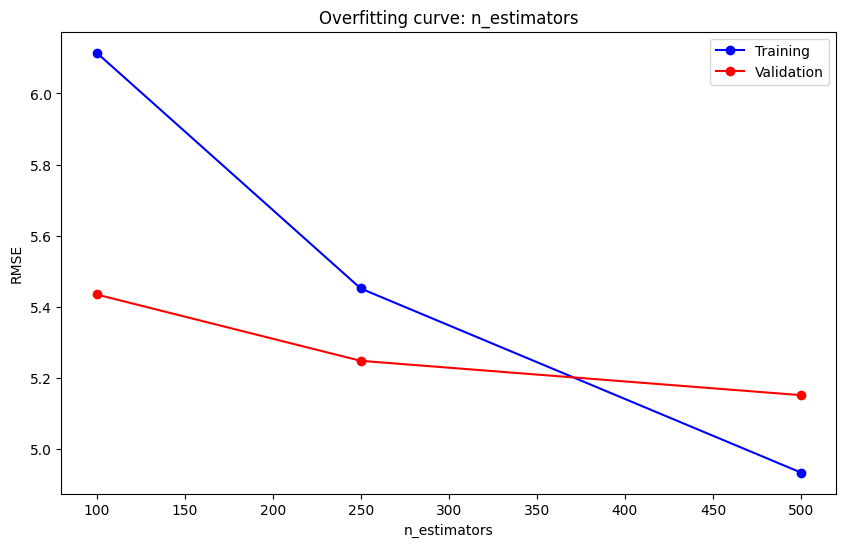

In [274]:
%%time 
test_param_and_plot(XGBRegressor, 'n_estimators', [100, 250, 500], **best_params)

In [281]:
best_params['n_estimators'] = 500

CPU times: user 25min 8s, sys: 2.06 s, total: 25min 10s
Wall time: 6min 32s


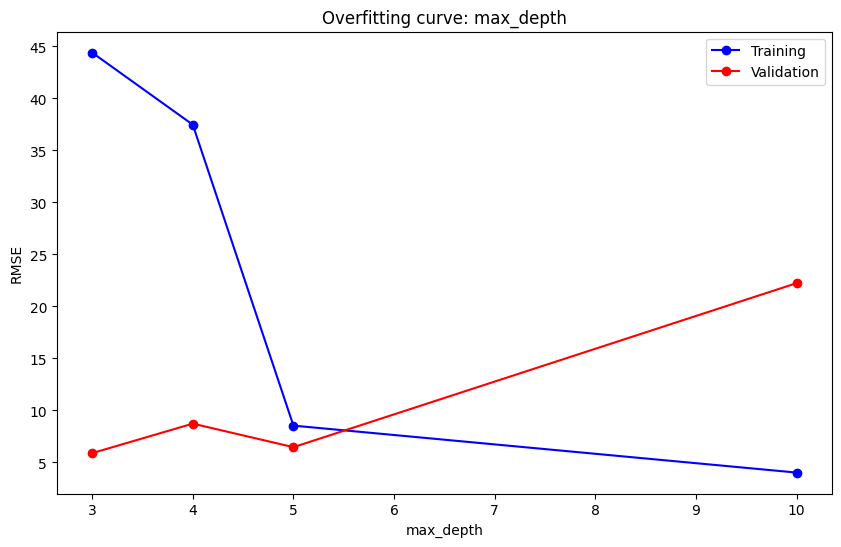

In [292]:
%%time 
test_param_and_plot(XGBRegressor, 'max_depth', [3, 4, 5, 10], **best_params)

In [293]:
best_params['max_depth'] = 5

CPU times: user 8min 20s, sys: 16.3 s, total: 8min 36s
Wall time: 2min 27s


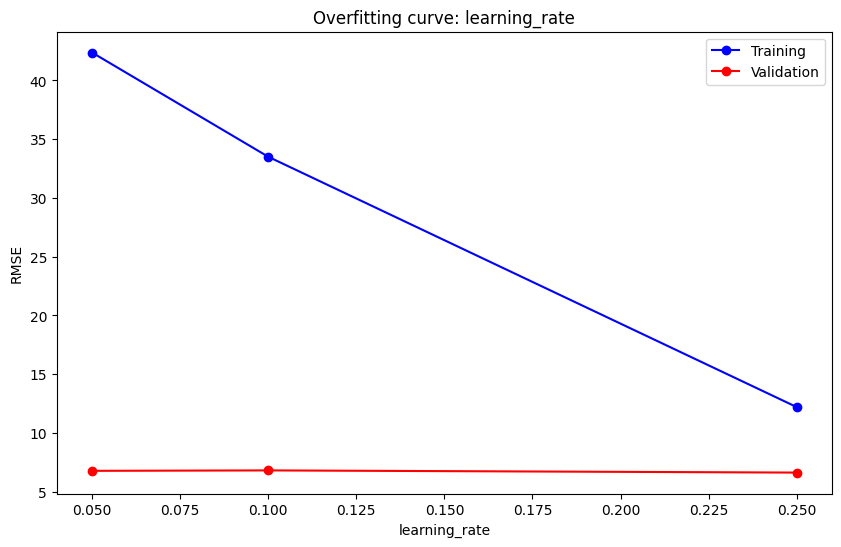

In [278]:
%%time
test_param_and_plot(XGBRegressor, 'learning_rate', [0.05, 0.1, 0.25], **best_params)

In [279]:
best_params['learning_rate'] = 0.25

In [294]:
xgb_model_final = XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=42,
                               n_estimators=500, max_depth=5, learning_rate=0.1, 
                               subsample=1, colsample_bytree=1)

In [295]:
%%time
xgb_model_final.fit(train_input, train_target)

CPU times: user 4min 1s, sys: 406 ms, total: 4min 1s
Wall time: 1min 2s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=-1, num_parallel_tree=None, random_state=42, ...)

In [296]:
evaluate(xgb_model_final)

(18.420961,
 8.317557,
 array([40.732853,  7.599393, 10.2471  , ..., 12.815859, 10.438755,
         9.272338], dtype=float32),
 array([10.407832 , 14.351728 ,  5.5584326, ...,  6.0500917,  5.331733 ,
         6.8424   ], dtype=float32))

In [291]:
predict_and_submit(xgb_model_final, test_inputs, 'xgb_tuned_submission.csv')

,key,fare_amount
0,2015-01-27 13:08:24.0000002,7.661262
1,2015-01-27 13:08:24.0000003,9.401181
2,2011-10-08 11:53:44.0000002,5.112157
3,2012-12-01 21:12:12.0000002,8.069266
4,2012-12-01 21:12:12.0000003,16.104788
...,...,...
9909,2015-05-10 12:37:51.0000002,8.359943
9910,2015-01-12 17:05:51.0000001,9.886791
9911,2015-04-19 20:44:15.0000001,52.356258
9912,2015-01-31 01:05:19.0000005,17.918966
